In [3]:
#@title Files for Import
import_file = "mlwpy.py" #@param {type:"string"}

#import libraries
import re
import importlib

#create regex
find = re.compile(r"^(.*?)\..*")
# extract file name before .py ending
import_file_no_ext = re.search(find, import_file).group(1)

# copy file to the current notebook
!cp '/content/drive/MyDrive/Colab Notebooks/imports/{import_file}' .
# import module
module = importlib.import_module(import_file_no_ext)

# is there an __all__? if so import all
if '__all__' in module.__dict__:
    names = module.__dict__['__all__']
else:
    # otherwise import all names that don't begin with _
    names = [x for x in module.__dict__ if not x.startswith('_')]

# now bring them in
globals().update({k: getattr(module, k) for k in names})

print(f'Imported file: {import_file_no_ext}.py')

# set matplotlib to display inline
%matplotlib inline

Imported file: mlwpy.py


In [14]:
#save default font settings
IPython_default = plt.rcParams.copy()

# set fonts / set text size
#@title matplotlib font settings
small_text = 15 #@param {type:"integer"}
medium_text = 26 #@param {type:"integer"}
large_text = 28 #@param {type:"integer"}
line_marker_size = 9.5 #@param {type:"slider", min:0, max:10, step:0.5}
legend_shadow = True #@param {type:"boolean"}
fig_width =  8 #@param {type:"number"}
fig_height =  6 #@param {type:"number"}
sns_style = "ticks" #@param ["darkgrid", "whitegrid", "dark", "white", "ticks"]
axis_grid = True #@param {type:"boolean"}
sns_palette = "deep" #@param ["pastel", "muted", "bright", "deep", "colorblind", "dark"]

import matplotlib.pyplot as plt
import seaborn as sns

# restore defaults
plt.rcdefaults()

#run configuration parameters
plt.rcParams['axes.labelsize']   = small_text
plt.rcParams['axes.titlesize']   = small_text
plt.rcParams['xtick.labelsize']  = small_text
plt.rcParams['ytick.labelsize']  = small_text
plt.rcParams['legend.fontsize']  = small_text
plt.rcParams['legend.shadow']    = legend_shadow
plt.rcParams['lines.markersize'] = line_marker_size
plt.rcParams['figure.figsize']   = (fig_width, fig_height)
plt.rcParams['font.size']        = small_text

# seaborn settings
sns.set_style(sns_style, {"axes.grid": axis_grid})
sns.set_palette(sns_palette)


In [5]:
# enable wordwrap
#https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
    td,th,p {
        font-size: 18px
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## 13.3 Principal Components Analysis: An Unsupervised Technique

Unsupervised techniques find patterns in data without appealing to target features. They apply a fixed standard and let the data express itself through the fixed lens.

Simple calculated statistics, like the mean and the variance, are unsupervised. They are calculated from the data with respect to a predefined standard that is not related to an explicit target.

Imagine we have a scatter plot of points drawn on transparent paper. If we place the transparency on a table, we can turn it clockwise and counterclockwise. If we had a set of *xy* axes underneath it on the table, we could align the data points with the axes so that the horizontal axis has the biggest spread in the data. By doing that, we let the data determine the *direction* of the axes.

A second visual piece that comes up with axes is the tick marks. Tick marks tell us the data *scale*. We could probably come up with several ways to determine scalle, but one that we've already seen is the *variance* of the data in any direction. If we put ticks at one, two, and three standard deviations, that's the square root of the variance, in the directions of the axes, thenwe have axes, with tick marks, that were developed based on the data without appealing to any target feature. The axes and ticks are based on the covariance and the variance of data. Principal components analysis gives us a principled way to determine thes edata-driven axes.

### 13.3.1 A Warm Up: Centering

PCA is a powerful technique. Before considering it, let's return to *centering* data which mirrors the process we'll use with PCA. There are two steps to centering a dataset. Calculate the mean of the data and then subtract the mean from each data point. In code it looks like the following:

In [6]:
data = np.array([[1, 2, 4, 5],
                 [2.5,.75,5.25,3.5]]).T
mean = data.mean(axis=0)
centered_data = data - mean                 

The reason we call this centering is because our points are now dispersed directly around the origin (0, 0) and the origin is the center of the geometric world. We moved from an arbitrary location to the center of the world. 

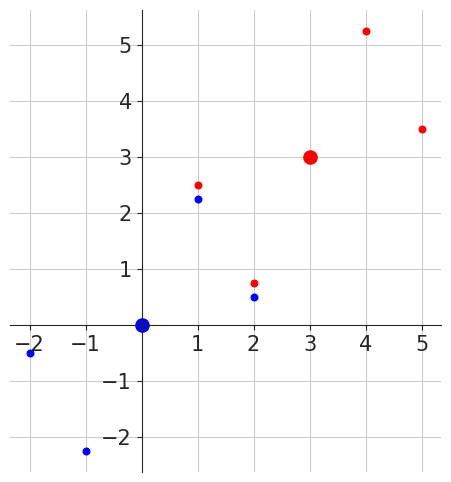

In [15]:
fig, ax = plt.subplots()

# original data in red;
# mean is larget data at (3,3)
ax.plot(*data.T, 'r.')
ax.plot(*mean, 'ro')

# centered data in blue, mean at (0,0)
ax.plot(*centered_data.T, 'b.')
ax.plot(*centered_data.mean(axis=0), 'bo')

 #ax.set_aspect('equal');
high_school_style(ax)

The mean is the best buess to minimize the distance from a point to any other value. It is the *closest* point, on average, to all the other points, whereas the *mode* is the *most likely* point and the *middle-most* point is the median. 

When we center data, we lost a bit of informatoin. Unless we write down the value of the mean that we subtracted, we no longer know the *actual* center of the data. We know how spread out the data is, but we no longer know whether average, unless we write it down.

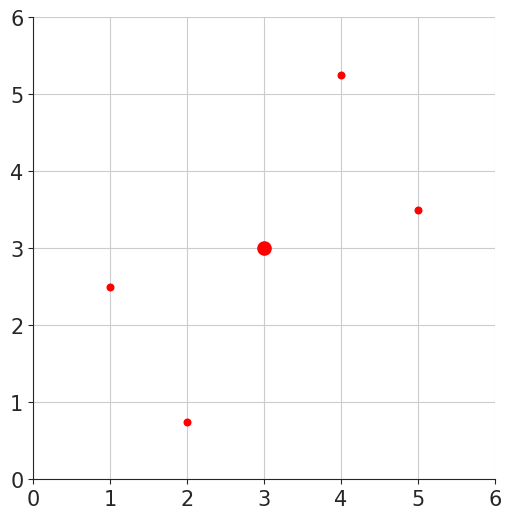

In [17]:
# we can reporude the original data
fig,ax = plt.subplots()
orig_data = centered_data + mean
plt.plot(*orig_data.T, 'r.')
plt.plot(*orig_data.mean(axis=0), 'ro')

ax.set_xlim((0,6))
ax.set_ylim((0,6))
high_school_style(ax)

Writing this symbolically, we get something like $D \xrightarrow{D - \mu} C_D \xrightarrow{C_{D} + \mu} D$.

We move from the original data $D$ to the centered data $C_D$ by subtracting the mean $\mu$ from the original.

Centering deals with shifting the data left-right and up-down. When we *standardized* data, we both centered and *scaled* the data. Wehn we perform principal components analysis, we are going to rotate, or spin, the data.



### 13.3.2 Finding a Different Best Line

When we performed linear regression, we dealt with differences between our line and the data in one direction: vertical. We *assumed* all the error was in our prediction of the *target* value. What is there is error or randomness in the *inputs*? Then, instead of calculating our error up and down, we need to account for bot a vertical *and* a horizontal component in our distance from the best-fitting line.

[[1.   2.5 ]
 [2.   0.75]
 [4.   5.25]
 [5.   3.5 ]]


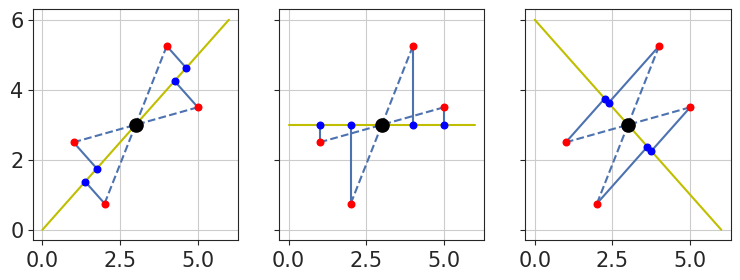

In [22]:
fig, axes = plt.subplots(1,3,figsize=(9, 3), sharex=True,sharey=True)
xs = np.linspace(0,6,30)
lines = [(1,0), (0,3), (-1,6)]
data = np.array([[1,  2,  4,   5  ],
                 [2.5,.75,5.25,3.5]]).T
print(data)
                
plot_lines_and_projections(axes, lines, data, xs)                

We drew three yellow lines and connected the samll red data points to the yellow line. They connect with the yellow line at their respective blue dots. More techincally, we say that we *project* the red dots to the blue dots. The solid blue lines are the distances from a red dot to a blue dot. The dashed blue lines are the distances from a red point to the mean, which is the larger black dot. The distance between a blue dot and the mean is a portion of the yellow line. Unless a red dot falls directly on the yellow line, it will be closer to the mean when we project it onto its blue companion. 

Using the formula: $ Y^2 + B_{solid}^2 = B_{dashed}^2 $ the yellow piece has to be smaller than the dashed line, unless the red point resides on the yellow line.

There are lots of yellow lines we could have drawn, but to cut down on the possibilities, we drew them all through the mean. The yellow lines show a fundamental tradeoff of *any* yellow line we could draw. Considering two aspects of these graphs: (1) how spread-out are the blue dots on the yellow line and (2) what is the total distance of the red points from the yellow line. 

The yellow line that has the *most spread-out blue dots* is also the one that has the *shortest total distance from the red points*. In more technical terms, we say that the line that leads to the *maximum variance* in the blue points is also the line with the *lowest error* from the red points.

When we perform PCA, the first step is to take the best line, which line has the *lowest error* and the *maximum variance*? We can continue the process and ask for the *next* best line that is perpendicular, at a right angle, to the first line. 

When we put these two lines together, we get a plane. We can keep going and add another direction for each feature we had in the original dataset. The *wine* dataset has 13 training features, so we could have as many as 13 directions. As it turns out, one use of PCA is to stop the process early so that we've (1) found some good directions and (2) reduced the total amount of information we keep around.


### 13.3.3 A First PCA

There is an automated alternative in `sklearn` that uses some underlying mathematics that tells us the best answer without trying different outcomes: Principal components analysis (PCA). PCA finds the best line under the minimum error and maximum variance constraints.

If we have found the best line--the best single direction--for a multifeatured dataset, we may then want to find the *second*-best direction. This is a direction with the most spread and the least error--with a slight constraint. We want the second direction to be perpendicular to the first direction. Since we are thinking about more than two features, there is more than one perpendicular possibility. To directions pick out a place.

PCA selects directions that maximize variance, minimize error, and are perpendicular to the already selected directions. PCA does this for all of the directions at once. Under ideal circumstances, we find one new direction for each feature in the dataset, although we usually stop early because we use PCA to *reduce* the dataset by reducing the total number of features we send into a learning algorithm.

Let's create some data, use `sklearn`'s `PCA` transformer on the data, and extract some useful pieces from the result. We translate two result components into things we want to draw: the principal directions of the data and the amount of variability in that direction. The directions tell us where the data-driven axes point. We'll see where the lengths of the arrows come from soon.



Lengths: [5.6067 1.2683]


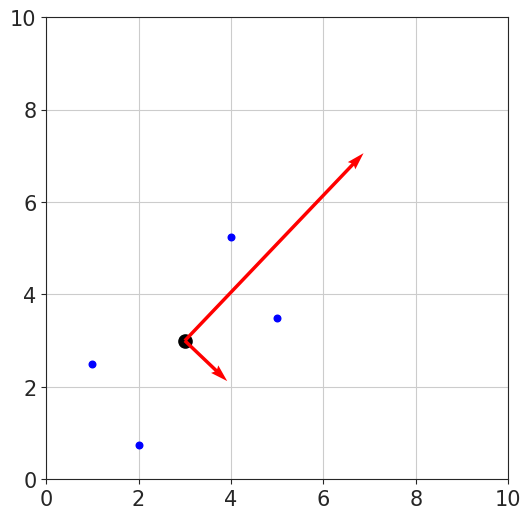

In [25]:
# draw data
ax = plt.gca()
ax.scatter(data[:,0], data[:,1], c='b', marker='.')

# draw mean
mean = np.mean(data, axis=0, keepdims=True)
centered_data = data - mean
ax.scatter(*mean.T, c='k')
# compute PCA
pca = decomposition.PCA()
P = pca.fit_transform(centered_data)

# extract useful bits for drawing
directions = pca.components_
lengths = pca.explained_variance_
print('Lengths:', lengths)
var_wgt_prindirs = -np.diag(lengths).dot(directions)
    # negate to point up/right

# draw principal axes
sane_quiver(var_wgt_prindirs, ax, origin=np.mean(data,axis=0), colors='r')
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_aspect('equal')    


If we tilt our heads, we have translated our data from an arbitrary orientation to a standard grid relative to the red arrows. We perform the last step without tilting our heads shortly. Let's talk about the covariance of the results. Shortly, we'll explain why we chose to draw the data axes with the lengths of `explained_variance`. Remember, the variance and the covariance are not affected by shifting the data. In other words, they are not affected by centering the data.

In [26]:
print(np.allclose(np.cov(data, rowvar=False),
                  np.cov(centered_data, rowvar=False)))

True


Statisticians sometimes care about the total amount of variation in the data. It comes from the diagonal entries of the covariance matrix. Since `data` and `centered_data` have the same covariance, we can use either to calculate the covariance. Here's the covariance matrix and the sum of the diagonal from top-left to bottom-right:

In [27]:
orig_cov = np.cov(centered_data, rowvar=False)
print(orig_cov)
print(np.diag(orig_cov).sum())

[[3.3333 2.1667]
 [2.1667 3.5417]]
6.875


When we perform PCA, we get a new set of directions with the same total amount of variance. However, our directions will distribute the variance in different ways. In fact, we pile as much of the total variance onto the first direction as possible. That variance is completely the same as the maximum variance/minimum error we discussed earlier. In the next direction, we get as much of the left-over variation as possible, and so forth. If we add up all the variances of the new directions, we see that we get the same total.

In [28]:
EPS = 2.2e-16 # EPS (epsilon) is computer-sciency for 'really small'
p_cov = np.cov(P, rowvar=False)
p_cov[p_cov<EPS] = 0.0 # throw out 'reall small' values
print(p_cov)
print(p_cov.sum())

[[5.6067 0.    ]
 [0.     1.2683]]
6.874999999999999


The diagonal values are the lengths used to draw the data axes. We see that `cov(P)` has all zero entries off of the diagonal. We eliminated the covariance between features. It is precisely because we chose directions via `PCA` that are not linearly related (they are at right angles) to each other. We have taken the liberty of replacing any suitably small values (less than `EPS`) with an exact `0.0` primarly to deal with floating-plint issues.

### 13.3.4 Under the Hood of PCA

We can take a look at what happens when `sklearn` calculates the PCA of a dataset. The standard way to perform PCA relies on singular value decomposition (SVD) of matrices. There are many reasons to show off this process: (1) the overall strategy and algorithm is straightfoward, (2) the tabular data as a matrix opens up a large window of opportunity to understand other techniques, and (3) it is a great intro to *why* you might ever want to study linear algebra.

One of the major tools of linear algebra is *matrix decompositions* or *matrix factorizations*, which are two names for the same sort of thing. When we decompose something, we break it down into its constituent parts. When we factor an integer, a whole number, we break it down into its component factors. $ 64 = 8 \times 8 $ or $ 24 = 12 \times 2 $. There are many ways to factor integers. If we seek pieces that can't be broken down further, this is called a *prime factorization.* Or, maybe we just ask for any pair of two factors. Or, we could ask if the number can be factored into values that are the same--is it a square, cube, etc.

Matrix decomposition is an equivalent process for matrices. We take a known matrix and ask how we can break it down into more primitive, smaller, component parts. What's interesting is that we can often talk about these parts in terms of how they affect a scatter plot or a data matrix. For the SVD of a matrix says that any data matrix can be factored into three components: a rotation or spinning, a stretching, and another rotation. Working backwards, if we start with the most vanilla data we can imagine, and we rotate, stretch, and rotate again, we can get any data matrix as a result. Another decomposition, the *eigendecomposition*, decomposes a matrix into a rotation, a stretch, and then an *undo* of the first rotation. Let's examine that here.

We'll need a helper that can rotate data points around the origin (0, 0) by a given angle:

In [30]:
def make_rotation(theta):
    ''' ccw rotation of theta when it post-multiplies
        a row vector (an example) '''
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta),  np.cos(theta)]]).T

With that, we create some points that are equally spaced around a circle and set an amount of rotation and scaling we want to perform

In [41]:
spacing = np.linspace(0,2*np.pi,17)
print(spacing)
points = np.c_[np.sin(spacing), np.cos(spacing)]
print(points)
# sin/cos walk around circle
two_points = points[[0,3]]
rot = make_rotation(np.pi/8) # 1/16th turn degrees ccw
scale = np.diag([2,.5])
print(two_points)

[0.     0.3927 0.7854 1.1781 1.5708 1.9635 2.3562 2.7489 3.1416 3.5343
 3.927  4.3197 4.7124 5.1051 5.4978 5.8905 6.2832]
[[ 0.      1.    ]
 [ 0.3827  0.9239]
 [ 0.7071  0.7071]
 [ 0.9239  0.3827]
 [ 1.      0.    ]
 [ 0.9239 -0.3827]
 [ 0.7071 -0.7071]
 [ 0.3827 -0.9239]
 [ 0.     -1.    ]
 [-0.3827 -0.9239]
 [-0.7071 -0.7071]
 [-0.9239 -0.3827]
 [-1.     -0.    ]
 [-0.9239  0.3827]
 [-0.7071  0.7071]
 [-0.3827  0.9239]
 [-0.      1.    ]]
[[0.     1.    ]
 [0.9239 0.3827]]


Then we put it all together to move from a vanilla circle to an interesting ellipse. Here's what it looks like:

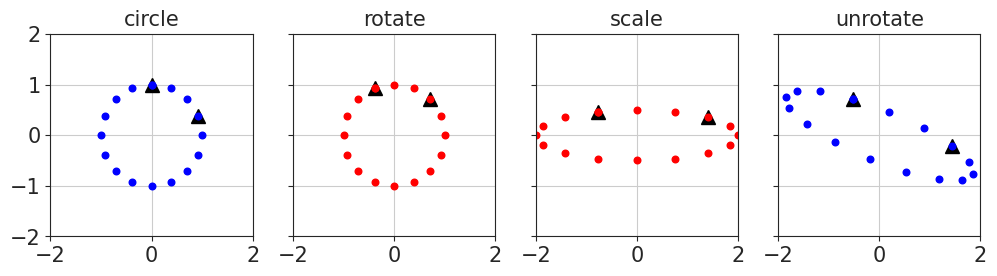

In [38]:
fig, axes = plt.subplots(1,4,figsize=(12,3), sharey=True)

# original vanilla circle
axes[0].plot(*two_points.T, 'k^')
axes[0].plot(*points.T, 'b.')

# make a rotation
axes[1].plot(*np.dot(two_points, rot).T, 'k^')
axes[1].plot(*np.dot(points, rot).T, 'r.')

# stretch along x and y axes
axes[2].plot(*two_points.dot(rot).dot(scale).T, 'k^')
axes[2].plot(*points.dot(rot).dot(scale).T, 'r.')

# undo initial rotation
axes[3].plot(*two_points.dot(rot).dot(scale).dot(rot.T).T, 'k^')
axes[3].plot(*points.dot(rot).dot(scale).dot(rot.T).T, 'b.')

names =[ 'circle', 'rotate', 'scale', 'unrotate']
for ax,name in zip(axes,names):
    ax.set_aspect('equal')
    ax.set_title(name)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)

What we did here is the *opposite* of factoring a number: we multiplied things together, like going from 3 and 5 to $3 \times 5 = 15$. Normally, we're given interesting data that we can describe with the rightmost ellipse, and we want to work backwards to the uninteresting leftmost circle to determine the bits we can use to compute a PCA.

To do that we need to know that a few things are *the same*. Whn we talk about similarity, there are some contraints. When we compute the SVD, the singular value decomposition (SVD). There are several places where the signs can be flipped and we get the same answer when we multiply things out, so either way is equally valid. The only problem is when two different methods try to do the SVD and pick different signs for the components. This difference means that when we say they give the *same* answer, we mean the answers are the *same up to some plus or minus signs.* We have the following helper routine that massages two different matrices into similar signs, it has a test on it that makes sure the matrices are numerically similar and have the same absolute values, before applying the sign fix.

In [42]:
def signs_like(A, B):
    ' produce new A,B with signs of A '
    assert np.allclose(np.abs(A), np.abs(B))
    signs = np.sign(A) * np.sign(B)
    return A, B * signs
signs_like([1,-1], [1,1])    

([1, -1], array([ 1, -1]))

Therefore, let's compute the SVD of our centered data. Basically, instead of factoring a number $15 = 5 \times 3$ , we are going to factor a matrix of our centered data: $D_C = USV^T$. We will compute the singular value decomposition and show that we have not lost anything. We can multiply together the components of the SVD--$U, S, V^T$--and we get back our centered data.

The code has a few components to simplify our lives. `full_matrices = False` and `S=np.diag(s)` makes the multiplication to reconstruct `centered_data` easier. We use `signs_like` to deal with the sign issue we discussed above. Lasly, and confusingly, `np.linalg.svd` returns a flipped--actually *transposed*, with rows turned into columns and columns into rows--version of `V`. We indicate this by assigning that part to `Vt`, the `t` standing for *transposed*. To get `V` itself, we unflip it with `.T` by taking `Vt.T`. Flipping twice gets us back to the original. Sometimes double negatives are a good thing.

In [43]:
N = len(centered_data)

U, s, Vt= np.linalg.svd(centered_data, full_matrices=False)
S = np.diag(s)
print(np.allclose(centered_data, U.dot(S).dot(Vt)))

True


`svd` plus a bit of work gave us `U`, `S`, and `V`. These components can be almost directly compared with the results from PCA. Here we check the directions, the variances, and the adjusted data:

In [44]:
# align signs
# note: U.S.Vt won't give centered now because
# U, Vt work together and we monkeyed with Vt
_, Vt = signs_like(pca.components_, Vt)
V = Vt.T

# directions come from Vt; amounts come from S
# divide by n-1 to get unbiased... see EOC
print(all((np.allclose(pca.components_,         Vt),
           np.allclose(pca.explained_variance_, s**2/(N-1)),
           np.allclose(P,                       centered_data.dot(V)))))

True


Now, recall that we can compute the covariance matrix from our centered data with a quick `dot`.

In [45]:
print('original covariance:\n', orig_cov)
print('centered covariance:\n',
      centered_data.T.dot(centered_data) / (N-1))

original covariance:
 [[3.3333 2.1667]
 [2.1667 3.5417]]
centered covariance:
 [[3.3333 2.1667]
 [2.1667 3.5417]]


Therefore, we just computed the PCA of our data by computing the SVD of our data. Another way to compute the PCA of our data is by computing the eigendecomposition (EIGD) of the *covariance matrix* of our data. There is a deep mathematical relationship and equivalence between `SVD(data)` and `EIGD(cov(data))`.

In [47]:
eigval, eigvec = np.linalg.eig(orig_cov)

# two differences:
# 1.  eigenvalues aren't ordered high to low (S from svd is ordered)
# 2.  final signs with SVD go through V *and* U, eigenvector is a bit 
#     different
order = np.argsort(eigval)[::-1]
print(np.allclose(eigval[order], s**2/(N-1)))

_,ev = signs_like(Vt,eigvec[:,order])
print(np.allclose(ev, Vt))

True
True
